In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

from utils import RWTH_COLORS

plt.style.use('paper.mplstyle')

In [9]:
pt = 1./72.27 # 72.27 points to an inch
text_width = 398.33862
fig_width = text_width * pt

golden = (1 + 5 ** 0.5) / 2
fig_height = fig_width / golden

print(f"Figure size: {fig_width:.2f} x {fig_height:.2f} inches")

Figure size: 5.51 x 3.41 inches


In [10]:
path = '/Users/julian/Library/CloudStorage/OneDrive-StudentsRWTHAachenUniversity/03 Research/02 BA/figures/thesis/background/'

# Gaussian Process

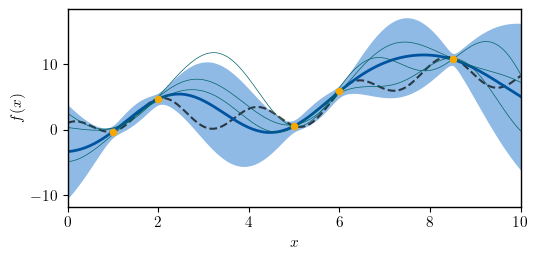

In [11]:
# Chart 1: Gaussian Process Concept Visualization

# Define a simple 1D function to approximate
def true_function(x):
    return 1 * (x) + 2 * np.sin(1 * x) + 2 * np.cos(3 * x) - 1 

# Generate training data
np.random.seed(40)
X_train = np.array([1.0, 2.0, 5.0, 6.0, 8.5]).reshape(-1, 1)
y_train = true_function(X_train.ravel()) + np.random.normal(0, 0.1, X_train.shape[0])

# Create test points for prediction
X_test = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = true_function(X_test.ravel())

# Fit Gaussian Process
kernel = C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.4**2, n_restarts_optimizer=15)
gp.fit(X_train, y_train)

# Make predictions
y_pred, sigma = gp.predict(X_test, return_std=True)

# Create the plot
fig, ax = plt.subplots(figsize=(fig_width, 0.8*fig_height))

# Plot confidence intervals
ax.fill_between(X_test.ravel(), y_pred - 2*sigma, y_pred + 2*sigma, 
                alpha=1, color=RWTH_COLORS['blue'][2], label='95% Confidence Interval')

# Plot true function
ax.plot(X_test.ravel(), y_true, 'k--', label='True Function', alpha=0.7)

# Plot GP posterior mean
ax.plot(X_test.ravel(), y_pred, color=RWTH_COLORS['blue'][0], label='GP Posterior Mean', linewidth=2)

# Plot selected functions drawn from the GP
for _ in range(3):
    y_sample = gp.sample_y(X_test, random_state=None).ravel()
    ax.plot(X_test.ravel(), y_sample, color=RWTH_COLORS['petrol'][0], linewidth=0.5)


# Plot training points
ax.scatter(X_train.ravel(), y_train, color=RWTH_COLORS['orange'][0], s=20, zorder=5, 
          label='Training Data')

# Formatting
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_xlim(0, 10)  # Remove padding on x-axis
#ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=4)

plt.tight_layout()
plt.savefig(path + 'gp_concept.pdf')
plt.show()

# Bayesian Optimization

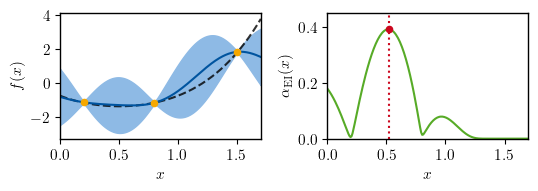

In [12]:
# Chart 2: Bayesian Optimization Concept Visualization

# Define an objective function to optimize (with a global minimum)
def objective_function(x):
    return -(-0.9*(1.4 - 3*x + 4*x**2 - 2*x**3 + x**4) + 2)

# Expected Improvement acquisition function for MINIMIZATION
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    
    mu_sample_opt = np.min(mu_sample)
    
    with np.errstate(divide='warn'):
        # For minimization: improvement = f_min - mu (we want lower values)
        imp = mu_sample_opt - mu - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei

# Initial sampling points
np.random.seed(42)
X_init = np.array([0.2, 0.8, 1.5]).reshape(-1, 1)
y_init = objective_function(X_init.ravel()) + np.random.normal(0, 0.05, X_init.shape[0])

# Test points
X_plot = np.linspace(0, 1.7, 200).reshape(-1, 1)
y_true_obj = objective_function(X_plot.ravel())

# Fit GP to initial data
kernel_bo = C(1.0) * RBF(0.5)
gp_bo = GaussianProcessRegressor(kernel=kernel_bo, alpha=0.05**2, n_restarts_optimizer=10)
gp_bo.fit(X_init, y_init)

# Predict with GP
y_pred_bo, sigma_bo = gp_bo.predict(X_plot, return_std=True)

# Calculate Expected Improvement
ei = expected_improvement(X_plot, X_init, y_init, gp_bo)

# Find next sampling point (maximum EI)
next_x = X_plot[np.argmax(ei)]

# Create the plot with subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, 0.6*fig_height), sharey=False)

# Left subplot: Objective function and GP
# Plot true objective
ax1.plot(X_plot.ravel(), y_true_obj, 'k--', label='True Objective', alpha=0.8)

# Plot GP mean and uncertainty
ax1.plot(X_plot.ravel(), y_pred_bo, label='GP Mean', color=RWTH_COLORS['blue'][0])
ax1.fill_between(X_plot.ravel(), y_pred_bo - 2*sigma_bo, y_pred_bo + 2*sigma_bo, 
                alpha=1, color=RWTH_COLORS['blue'][2], label='95% Confidence')

# Plot sampled points
ax1.scatter(X_init.ravel(), y_init, color=RWTH_COLORS['orange'][0], s=20, zorder=5, 
           label='Observed Points')

# Formatting left subplot
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$f(x)$')
#ax1.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=4)
ax1.set_xticks(np.arange(0, 1.8, 0.5))
ax1.set_xlim(0, 1.7)

# Right subplot: Acquisition function
ax2.plot(X_plot.ravel(), ei.ravel(), color=RWTH_COLORS['green'][0], label='Expected Improvement')

# Highlight next sampling point
ax2.axvline(next_x, color=RWTH_COLORS['red'][0], linestyle=':', 
           label=f'Next Sample Point\n(x = {next_x[0]:.2f})')
ax2.scatter(next_x, np.max(ei), color=RWTH_COLORS['red'][0], s=20, zorder=5)

# Formatting right subplot
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\alpha_{\text{EI}}(x)$')
#ax2.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=4)
ax2.set_xticks(np.arange(0, 2, 0.5))
ax2.set_xlim(0, 1.7)
ax2.set_ylim(0, 0.45)

plt.tight_layout()
plt.savefig(path + 'bo_concept.pdf')
plt.show()

# Output Transformations

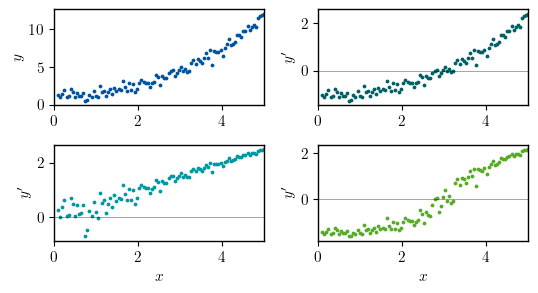

Transformation Statistics:
Original data - Mean: 4.512, Std: 3.166
Standardized - Mean: 0.000, Std: 1.000
Log transform - Mean: 1.233, Std: 0.775
Bilog transform - Mean: -0.132, Std: 1.278


In [13]:
# Chart 3: Data Transformation Comparison

# Generate sample data with different characteristics
np.random.seed(42)
n_samples = 100

# Create sample data with exponential-like distribution (suitable for log transform)
x_data = np.linspace(0.1, 5, n_samples)
y_original = np.exp(0.5 * x_data) + np.random.normal(0, 0.5, n_samples)
y_original = np.clip(y_original, 1e-10, None)  # Ensure positive values for log transform

# Define transformation functions
def standardize_transform(data):
    """Standardize data to have mean=0 and std=1"""
    return (data - np.mean(data)) / np.std(data)

def log_transform(data):
    """Apply log transformation (log base 10)"""
    return np.log(data)  # Avoid log(0)

def bilog_transform(data):
    """Apply bi-logarithmic transformation: sign(y) * log1p(abs(y))"""
    return np.sign(data) * np.log1p(np.abs(data))

# Apply transformations
y_standardized = standardize_transform(y_original)
y_log = log_transform(y_original)

# For bilog, create data with positive and negative values
y_bilog_data = y_original - np.mean(y_original)  # Center around 0
y_bilog = bilog_transform(y_bilog_data)

# Create single figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(fig_width, 0.9*fig_height))

# Top left: Original data
ax1.scatter(x_data, y_original, c=RWTH_COLORS['blue'][0], s=3, alpha=1)
#ax1.set_title('Original Data', pad=15)
#ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
ax1.set_xlim(0, 5)

# Top right: Standardized data
ax2.scatter(x_data, y_standardized, c=RWTH_COLORS['petrol'][0], s=3, alpha=1)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
# ax2.fill_between(x_data, -1, 1, alpha=0.2, color='#939598', label='±1 Std Dev')
#ax2.set_title('Standardized Transform', pad=15)
#ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y^{\prime}$')
ax2.set_xlim(0, 5)
#ax2.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=4)

# Bottom left: Log transformed data
ax3.scatter(x_data, y_log, c=RWTH_COLORS['tuerkis'][0], s=3, alpha=1)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
#ax3.set_title('Logarithmic Transform', pad=15)
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$y^{\prime}$')
ax3.set_xlim(0, 5)

# Bottom right: Bilog transformed data
ax4.scatter(x_data, y_bilog, c=RWTH_COLORS['green'][0], s=3, alpha=1)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
#ax4.set_title('Bi-logarithmic Transform', pad=15)
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$y^{\prime}$')
ax4.set_xlim(0, 5)

plt.tight_layout()
plt.savefig(path + 'transforms_comparison.pdf')
plt.show()

# Print transformation statistics
print("Transformation Statistics:")
print(f"Original data - Mean: {np.mean(y_original):.3f}, Std: {np.std(y_original):.3f}")
print(f"Standardized - Mean: {np.mean(y_standardized):.3f}, Std: {np.std(y_standardized):.3f}")
print(f"Log transform - Mean: {np.mean(y_log):.3f}, Std: {np.std(y_log):.3f}")
print(f"Bilog transform - Mean: {np.mean(y_bilog):.3f}, Std: {np.std(y_bilog):.3f}")

# Beam Search

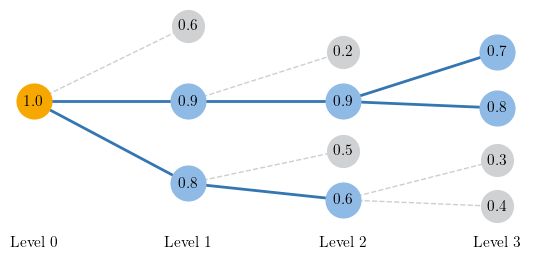

In [14]:
import matplotlib.lines as mlines

# Define the beam search tree structure (horizontal)
# Each node has: (x, y, score, level, kept_in_beam)
nodes = {
    # Level 0 (root)
    'root': (0.1, 0.5, 1.0, 0, True),
    
    # Level 1
    'A': (0.3, 0.25, 0.8, 1, True),
    'B': (0.3, 0.5, 0.9, 1, True),
    'C': (0.3, 0.73, 0.6, 1, False),
    
    # Level 2
    'A1': (0.5, 0.2, 0.6, 2, True),
    'A2': (0.5, 0.35, 0.5, 2, False),
    'B1': (0.5, 0.5, 0.9, 2, True),
    'B2': (0.5, 0.65, 0.2, 2, False),
    
    # Level 3
    'A1a': (0.7, 0.18, 0.4, 3, False),
    'A1b': (0.7, 0.32, 0.3, 3, False),
    'B1a': (0.7, 0.48, 0.8, 3, True),
    'B1b': (0.7, 0.65, 0.7, 3, True),
}

# Define connections (parent -> child)
connections = [
    ('root', 'A'), ('root', 'B'), ('root', 'C'),
    ('A', 'A1'), ('A', 'A2'), ('B', 'B1'), ('B', 'B2'),
    ('A1', 'A1a'), ('A1', 'A1b'), ('B1', 'B1a'), ('B1', 'B1b')
]

# Create the plot with better proportions
fig, ax = plt.subplots(figsize=(fig_width, 0.8*fig_height))

for parent, child in connections:
    if parent in nodes and child in nodes:
        px, py = nodes[parent][:2]
        cx, cy = nodes[child][:2]
        
        # Check if both nodes are kept in beam
        parent_kept = nodes[parent][4]
        child_kept = nodes[child][4]
        
        if parent_kept and child_kept:
            # Active path
            ax.plot([px, cx], [py, cy], color=RWTH_COLORS['blue'][0], 
                   linewidth=2, alpha=0.8, zorder=1)
        elif parent_kept:
            # Path from active node to pruned node
            ax.plot([px, cx], [py, cy], color=RWTH_COLORS['black'][2], 
                   linewidth=1, alpha=0.5, linestyle='--', zorder=1)

# Draw nodes
for node_name, (x, y, score, level, kept) in nodes.items():
    if kept:
        # Active nodes (kept in beam)
        if level == 0:
            color = RWTH_COLORS['orange'][0]  # Root node
        else:
            color = RWTH_COLORS['blue'][2]    # Active nodes
        alpha = 1.0
        size = 600
    else:
        # Pruned nodes
        color = RWTH_COLORS['black'][3]
        alpha = 1.0
        size = 500
    
    # Draw node
    ax.scatter(x, y, c=color, s=size, alpha=alpha, linewidth=1.5, zorder=3)
    
    # Add score text
    if kept:
        ax.text(x, y, f'{score:.1f}', ha='center', va='center', zorder=4)
    else:
        ax.text(x, y, f'{score:.1f}', ha='center', va='center', alpha=1, zorder=4)

# Add level labels
level_positions = [0.1, 0.3, 0.5, 0.7]
for i, x_pos in enumerate(level_positions):
    ax.text(x_pos, 0.05, f'Level {i}', ha='center', va='bottom')

# Add legend
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=RWTH_COLORS['orange'][0], 
                  markersize=12, label='Root Node'),
    mlines.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=RWTH_COLORS['blue'][2], 
                  markersize=12, label='Active Nodes (Top-k)'),
    mlines.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=RWTH_COLORS['black'][3], 
                  markersize=12, alpha=1, label='Pruned Nodes'),
    mlines.Line2D([0], [0], color=RWTH_COLORS['blue'][2], 
                  linewidth=2, label='Active Paths'),
    mlines.Line2D([0], [0], color=RWTH_COLORS['black'][2], 
                  linewidth=1, linestyle='--', alpha=1, label='Pruned Paths', zorder=1)
]

ax.set_xlim(0.076, 0.735)
ax.set_ylim(0.05, 0.78)
ax.axis('off') 

plt.tight_layout()
plt.savefig(path + 'beam_search_concept.pdf')
plt.show()